#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements the TAVIE algorithm as developed in:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

In [1]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
from TAVIE import *
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
from CompetingMethods import *
from time import perf_counter
from tqdm import tqdm, trange
from scipy.stats import t
import pandas as pd

## Comparing our TAVIE algorithm for Laplace location-scale family (Type I)

**Competing method: black-box variational inference (BBVI)**

In [4]:
# TAVIE model initialization
laplace_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

# Experiment parameters
n = 10000
p = 6
tau2_true = 3
num_reps = 50

# Containers for metrics
mse_beta_BBVI = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_tau2_BBVI = np.zeros(num_reps)
mse_tau2_TAVIE = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)

# True beta vector
beta_true = np.random.normal(loc=2.0, scale=1.0, size=p+1)

# Main loop with progress bar for TAVIE and BBVI results
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    
    error = np.random.laplace(size=n, scale=1/np.sqrt(tau2_true))
    y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

    # TAVIE estimator
    t0 = perf_counter()
    laplace_model.fit(X, y, verbose=False) # fitting the TAVIE model for laplace
    time_TAVIE[rep] = perf_counter() - t0
    beta_est, tau2_est = laplace_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est - beta_true)**2)
    mse_tau2_TAVIE[rep] = (tau2_est - tau2_true)**2
    
    # BBVI estimator
    t0 = perf_counter()
    res2 = BBVI_Laplace(X_bbvi, y)
    time_BBVI[rep] = perf_counter() - t0
    beta_est2 = res2['beta_mean']
    tau2_est2 = res2['tau2_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est2 - beta_true)**2)
    mse_tau2_BBVI[rep] = (tau2_est2 - tau2_true)**2

Repetitions: 100%|██████████████████████████████| 50/50 [03:29<00:00,  4.20s/it]


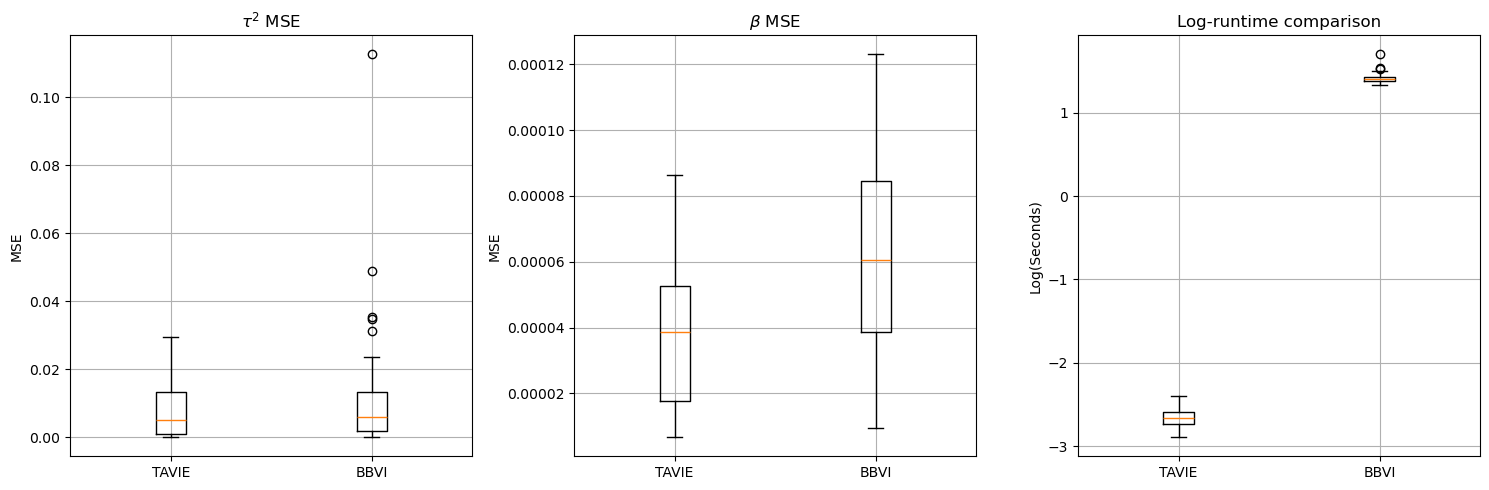

In [5]:
# Plotting results for TAVIE and BBVI
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Tau^2 MSE comparison
axes[0].boxplot([mse_tau2_TAVIE, mse_tau2_BBVI], tick_labels=['TAVIE', 'BBVI'])
axes[0].set_title(r'$\tau^2$ MSE')
axes[0].set_ylabel('MSE')
axes[0].grid(True)

# Beta MSE comparison
axes[1].boxplot([mse_beta_TAVIE, mse_beta_BBVI], tick_labels=['TAVIE', 'BBVI'])
axes[1].set_title(r'$\beta$ MSE')
axes[1].set_ylabel('MSE')
axes[1].grid(True)

# Runtime comparison
axes[2].boxplot([np.log(time_TAVIE), np.log(time_BBVI)], tick_labels=['TAVIE', 'BBVI'])
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Comparing our TAVIE algorithm for Student's-t location-scale family (Type I)

**Competing methods:**
* **black-box variational inference (BBVI)** and
* **mean-field variational inference (MFVI)**

The MFVI for Student's-t has been implemented in CompetingMethods/mfvi.py following Wand et al., 2011 <doi:10.1214/11-BA631>.

In [17]:
# TAVIE model initialization
t_model = TAVIE_loc_scale(family="student", fit_intercept=True)

# Experiment parameters
n = 10000
p = 5
nu_true = 2
tau2_true = 2
num_reps = 500

# Containers for metrics
mse_beta_MFVI = np.zeros(num_reps)
mse_beta_BBVI = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_tau2_MFVI = np.zeros(num_reps)
mse_tau2_BBVI = np.zeros(num_reps)
mse_tau2_TAVIE = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_MFVI = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)

# True beta vector
beta_true = np.random.normal(loc=2.0, scale=1.0, size=p+1)

# Main loop with progress bar
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    
    error = t.rvs(df=nu_true, size=n) / np.sqrt(tau2_true)
    y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

    # TAVIE estimator
    t0 = perf_counter()
    t_model.fit(X, y, nu=nu_true, verbose=False) # fitting the TAVIE model for Student's-t
    time_TAVIE[rep] = perf_counter() - t0
    beta_est, tau2_est = t_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est - beta_true)**2)
    mse_tau2_TAVIE[rep] = (tau2_est - tau2_true)**2
    

    # MFVI estimator
    t0 = perf_counter()
    beta_hat, sigma_sq_hat, nu_hat = MFVI_Student(X_bbvi, y, 
                                                  mu_beta=np.zeros(p+1), Sigma_beta=np.eye(p+1), 
                                                  A=2, B=2, nu_min=2.0, 
                                                  nu_max=20.0, tol=1e-6, verbose = False)
    time_MFVI = perf_counter() - t0
    beta_est2 = beta_hat
    tau2_est2 = 1/sigma_sq_hat
    mse_beta_MFVI[rep] = np.mean((beta_est2 - beta_true)**2)
    mse_tau2_MFVI[rep] = (tau2_est2 - tau2_true)**2

    # BBVI estimator
    t0 = perf_counter()
    res2 = BBVI_student(X_bbvi, y, nu=nu_true)
    time_BBVI[rep] = perf_counter() - t0
    beta_est3 = res2['beta_mean']
    tau2_est3 = res2['tau2_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est3 - beta_true)**2)
    mse_tau2_BBVI[rep] = (tau2_est3 - tau2_true)**2

Repetitions: 100%|████████████████████████████| 500/500 [47:47<00:00,  5.73s/it]


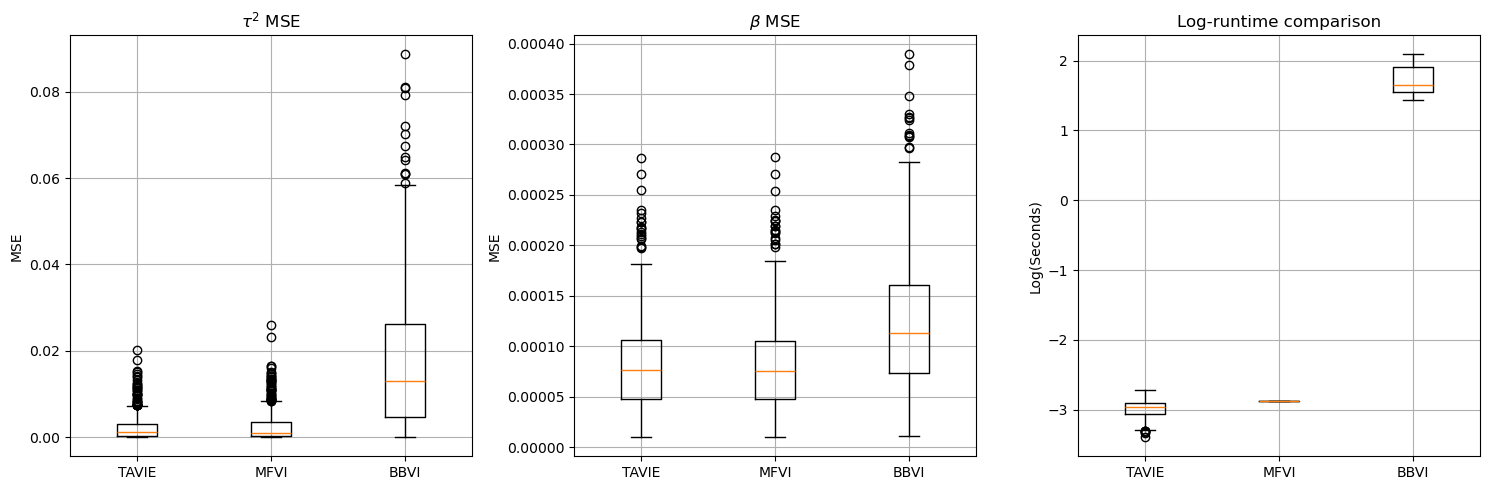

In [18]:
# Plotting results for TAVI, MFVI, and BBVI
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Tau^2 MSE comparison
axes[0].boxplot([mse_tau2_TAVIE, mse_tau2_MFVI, mse_tau2_BBVI], tick_labels=['TAVIE', 'MFVI', 'BBVI'])
axes[0].set_title(r'$\tau^2$ MSE')
axes[0].set_ylabel('MSE')
axes[0].grid(True)

# Beta MSE comparison
axes[1].boxplot([mse_beta_TAVIE, mse_beta_MFVI, mse_beta_BBVI], tick_labels=['TAVIE', 'MFVI', 'BBVI'])
axes[1].set_title(r'$\beta$ MSE')
axes[1].set_ylabel('MSE')
axes[1].grid(True)

# Runtime comparison
axes[2].boxplot([np.log(time_TAVIE), np.log(time_MFVI), np.log(time_BBVI)], tick_labels=['TAVIE', 'MFVI', 'BBVI'])
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Comparing our TAVIE algorithm for Logistic family (Type II)

**Competing methods:**
* **black-box variational inference (BBVI)**,
* **mean-field variational inference (MFVI)**, and
* **stochastic variational inference (SVI)**

The MFVI (CAVI) and SVI for Bayesian logistic regression has been implemented in CompetingMethods/mfvi.py following Durante and Rigon, 2019 <https://doi.org/10.1214/19-STS712>.

In [2]:
# TAVIE model initialization
logit_model = TAVIE_type_II(family="binomial", fit_intercept=True)

# Experiment parameters
n = 10000
p = 6
num_reps = 50

# Containers for metrics
mse_beta_CAVI = np.zeros(num_reps)
mse_beta_SVI = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_beta_BBVI = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_CAVI = np.zeros(num_reps)
time_SVI = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)

prior = {
    'mu'   : np.zeros(p+1),
    'Sigma': np.eye(p+1)
}

beta_true = np.random.normal(loc=2.0, scale=1.0, size=p+1)

# Main loop with progress bar
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
     
    linear_term = beta_true[0] + X @ beta_true[1:len(beta_true)]
    probs       = 1 / (1 + np.exp(-linear_term))
    y           = np.random.binomial(1, probs, size=n)

    # TAVIE estimator
    t0 = perf_counter()
    logit_model.fit(X, y, r=1, maxiter = 5000, verbose=False) # fitting the TAVIE model for logistic
    time_TAVIE[rep] = perf_counter() - t0
    beta_est1 = logit_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est1 - beta_true)**2)
    
    # CAVI estimator
    t0 = perf_counter()
    res2 = logit_cavi(X_bbvi, y, prior_params=prior,verbose=False)
    time_CAVI = perf_counter() - t0
    beta_est2 = res2['mu']
    mse_beta_CAVI[rep] = np.mean((beta_est2 - beta_true)**2)

    # SVI estimator
    t0 = perf_counter()
    res3 = logit_svi(
        X_bbvi,
        y,
        prior_params=prior,
        n_iter=10_000,
        tau=1.0,
        kappa=0.75,
        verbose=False,
        seed=123
    )
    time_SVI[rep] = perf_counter() - t0
    beta_est3 = res3['mu']
    mse_beta_SVI[rep] = np.mean((beta_est3 - beta_true)**2)

    # BBVI estimator
    t0 = perf_counter()
    res4 = BBVI_Logistic_patience(X_bbvi, y)
    time_BBVI[rep] = perf_counter() - t0
    beta_est4 = res4['beta_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est4 - beta_true)**2)

Repetitions:   2%|▌                              | 1/50 [00:02<02:22,  2.91s/it]

Early stopping at iter 2162: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:   4%|█▏                             | 2/50 [00:04<01:43,  2.15s/it]

Early stopping at iter 1944: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:   6%|█▊                             | 3/50 [00:06<01:28,  1.89s/it]

Early stopping at iter 1683: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:   8%|██▍                            | 4/50 [00:07<01:22,  1.80s/it]

Early stopping at iter 1904: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  10%|███                            | 5/50 [00:09<01:16,  1.70s/it]

Early stopping at iter 1732: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  12%|███▋                           | 6/50 [00:11<01:15,  1.72s/it]

Early stopping at iter 2134: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  14%|████▎                          | 7/50 [00:12<01:12,  1.68s/it]

Early stopping at iter 1772: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  16%|████▉                          | 8/50 [00:14<01:09,  1.65s/it]

Early stopping at iter 1791: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  18%|█████▌                         | 9/50 [00:16<01:09,  1.69s/it]

Early stopping at iter 1764: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  20%|██████                        | 10/50 [00:17<01:08,  1.71s/it]

Early stopping at iter 1923: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  22%|██████▌                       | 11/50 [00:19<01:03,  1.63s/it]

Early stopping at iter 1572: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  24%|███████▏                      | 12/50 [00:20<01:01,  1.61s/it]

Early stopping at iter 1806: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  26%|███████▊                      | 13/50 [00:22<01:00,  1.62s/it]

Early stopping at iter 1648: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  28%|████████▍                     | 14/50 [00:23<00:55,  1.54s/it]

Early stopping at iter 1200: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  30%|█████████                     | 15/50 [00:25<00:55,  1.58s/it]

Early stopping at iter 2018: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  32%|█████████▌                    | 16/50 [00:26<00:52,  1.55s/it]

Early stopping at iter 1727: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  34%|██████████▏                   | 17/50 [00:28<00:54,  1.66s/it]

Early stopping at iter 2064: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  36%|██████████▊                   | 18/50 [00:30<00:57,  1.79s/it]

Early stopping at iter 2822: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  38%|███████████▍                  | 19/50 [00:32<00:55,  1.77s/it]

Early stopping at iter 2134: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  40%|████████████                  | 20/50 [00:34<00:50,  1.67s/it]

Early stopping at iter 1638: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  42%|████████████▌                 | 21/50 [00:36<00:51,  1.77s/it]

Early stopping at iter 2887: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  44%|█████████████▏                | 22/50 [00:37<00:44,  1.60s/it]

Early stopping at iter 1236: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  46%|█████████████▊                | 23/50 [00:38<00:42,  1.58s/it]

Early stopping at iter 1791: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  48%|██████████████▍               | 24/50 [00:40<00:43,  1.67s/it]

Early stopping at iter 2558: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  50%|███████████████               | 25/50 [00:42<00:41,  1.66s/it]

Early stopping at iter 2053: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  52%|███████████████▌              | 26/50 [00:43<00:38,  1.59s/it]

Early stopping at iter 1681: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  54%|████████████████▏             | 27/50 [00:45<00:35,  1.53s/it]

Early stopping at iter 1473: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  56%|████████████████▊             | 28/50 [00:46<00:34,  1.56s/it]

Early stopping at iter 1767: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  58%|█████████████████▍            | 29/50 [00:48<00:34,  1.62s/it]

Early stopping at iter 1972: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  60%|██████████████████            | 30/50 [00:50<00:33,  1.68s/it]

Early stopping at iter 2157: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  62%|██████████████████▌           | 31/50 [00:51<00:30,  1.59s/it]

Early stopping at iter 1491: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  64%|███████████████████▏          | 32/50 [00:53<00:29,  1.65s/it]

Early stopping at iter 2247: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  66%|███████████████████▊          | 33/50 [00:55<00:29,  1.72s/it]

Early stopping at iter 2484: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  68%|████████████████████▍         | 34/50 [00:57<00:29,  1.83s/it]

Early stopping at iter 2769: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  70%|█████████████████████         | 35/50 [00:59<00:27,  1.82s/it]

Early stopping at iter 2249: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  72%|█████████████████████▌        | 36/50 [01:01<00:24,  1.77s/it]

Early stopping at iter 2011: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  74%|██████████████████████▏       | 37/50 [01:02<00:23,  1.81s/it]

Early stopping at iter 2233: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  76%|██████████████████████▊       | 38/50 [01:04<00:21,  1.80s/it]

Early stopping at iter 2206: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  78%|███████████████████████▍      | 39/50 [01:06<00:19,  1.76s/it]

Early stopping at iter 1997: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  80%|████████████████████████      | 40/50 [01:07<00:16,  1.63s/it]

Early stopping at iter 1325: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  82%|████████████████████████▌     | 41/50 [01:09<00:14,  1.64s/it]

Early stopping at iter 1866: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  84%|█████████████████████████▏    | 42/50 [01:11<00:14,  1.81s/it]

Early stopping at iter 2894: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  86%|█████████████████████████▊    | 43/50 [01:13<00:12,  1.82s/it]

Early stopping at iter 2241: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  88%|██████████████████████████▍   | 44/50 [01:15<00:11,  1.84s/it]

Early stopping at iter 2129: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  90%|███████████████████████████   | 45/50 [01:17<00:09,  1.91s/it]

Early stopping at iter 2479: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  92%|███████████████████████████▌  | 46/50 [01:19<00:07,  1.91s/it]

Early stopping at iter 2444: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  94%|████████████████████████████▏ | 47/50 [01:20<00:05,  1.79s/it]

Early stopping at iter 1751: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  96%|████████████████████████████▊ | 48/50 [01:22<00:03,  1.70s/it]

Early stopping at iter 1592: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions:  98%|█████████████████████████████▍| 49/50 [01:23<00:01,  1.67s/it]

Early stopping at iter 1596: no ELBO gain ≥ 0.001 for 500 iters.


Repetitions: 100%|██████████████████████████████| 50/50 [01:25<00:00,  1.72s/it]

Early stopping at iter 2259: no ELBO gain ≥ 0.001 for 500 iters.


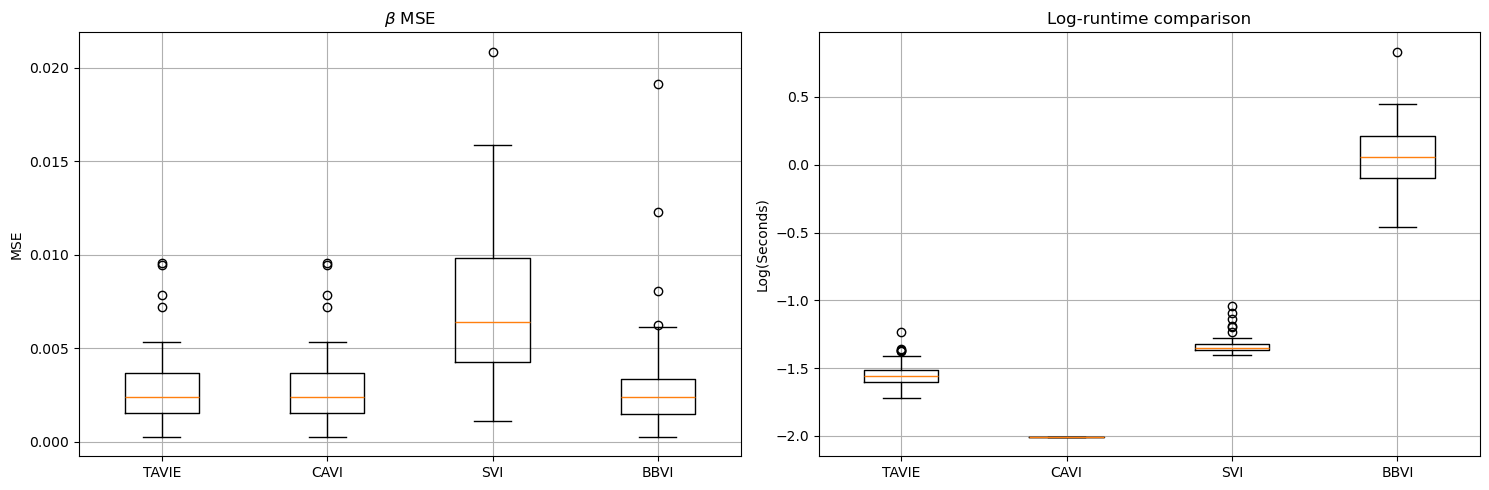

In [3]:
# Plotting results for TAVIE, CAVI, SVI, and BBVI
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Beta MSE comparison
axes[0].boxplot([mse_beta_TAVIE, mse_beta_CAVI, mse_beta_SVI, mse_beta_BBVI], tick_labels=['TAVIE', 'CAVI', 'SVI', 'BBVI'])
axes[0].set_title(r'$\beta$ MSE')
axes[0].set_ylabel('MSE')
#axes[0].set_ylim(0, 0.5)
axes[0].grid(True)

# Runtime comparison
axes[1].boxplot([np.log(time_TAVIE), np.log(time_CAVI), np.log(time_SVI), np.log(time_BBVI)], 
                tick_labels=['TAVIE', 'CAVI', 'SVI', 'BBVI'])
axes[1].set_title('Log-runtime comparison')
axes[1].set_ylabel('Log(Seconds)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Comparing our TAVIE algorithm for Negative-Binomial family (Type II)

**Competing method: black-box variational inference (BBVI)**

In [6]:
# TAVIE model initialization
negbin_model = TAVIE_type_II(family="negbin", fit_intercept=True)

# Experiment parameters
n = 10000
p = 10
r = 20
num_reps = 50

# Containers for metrics
mse_beta_TAVIE = np.zeros(num_reps)
mse_beta_BBVI = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)

beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Main loop with progress bar
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)]
    probs = 1 / (1 + np.exp(-linear_term))
    y = np.random.negative_binomial(r, probs, size=n)

    # TAVIE estimator
    t0 = perf_counter()
    negbin_model.fit(X, y, r=r, maxiter = 20000, verbose=False) # Fitting the TAVIE model for Negative-Binomial
    time_TAVIE[rep] = perf_counter() - t0
    beta_est1 = negbin_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est1 - beta_true)**2)
    

    # BBVI estimator
    t0 = perf_counter()
    res2 = BBVI_NegBin_patience(X_bbvi, y, r=r, tol=1e-5)
    time_BBVI[rep] = perf_counter() - t0
    beta_est2 = res2['beta_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est2 - beta_true)**2)

Repetitions:   2%|▌                              | 1/50 [00:02<01:54,  2.34s/it]

Early stopping at iter 3408: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   4%|█▏                             | 2/50 [00:03<01:08,  1.43s/it]

Early stopping at iter 997: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   6%|█▊                             | 3/50 [00:04<00:59,  1.27s/it]

Early stopping at iter 1423: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   8%|██▍                            | 4/50 [00:05<00:55,  1.20s/it]

Early stopping at iter 1441: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  10%|███                            | 5/50 [00:06<00:48,  1.08s/it]

Early stopping at iter 1142: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  12%|███▋                           | 6/50 [00:09<01:16,  1.74s/it]

Early stopping at iter 4662: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  14%|████▎                          | 7/50 [00:10<01:05,  1.53s/it]

Early stopping at iter 1477: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  16%|████▉                          | 8/50 [00:13<01:24,  2.02s/it]

Early stopping at iter 4407: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  18%|█████▌                         | 9/50 [00:17<01:43,  2.53s/it]

Early stopping at iter 4290: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  20%|██████                        | 10/50 [00:19<01:40,  2.51s/it]

Early stopping at iter 3465: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  22%|██████▌                       | 11/50 [00:21<01:31,  2.33s/it]

Early stopping at iter 2928: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  24%|███████▏                      | 12/50 [00:24<01:34,  2.48s/it]

Early stopping at iter 4181: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  26%|███████▊                      | 13/50 [00:25<01:19,  2.14s/it]

Early stopping at iter 1957: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  28%|████████▍                     | 14/50 [00:26<01:05,  1.83s/it]

Early stopping at iter 1583: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  30%|█████████                     | 15/50 [00:28<00:59,  1.70s/it]

Early stopping at iter 1934: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  32%|█████████▌                    | 16/50 [00:30<01:00,  1.78s/it]

Early stopping at iter 2982: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  34%|██████████▏                   | 17/50 [00:31<00:56,  1.70s/it]

Early stopping at iter 2247: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  36%|██████████▊                   | 18/50 [00:33<00:53,  1.67s/it]

Early stopping at iter 2210: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  38%|███████████▍                  | 19/50 [00:34<00:50,  1.64s/it]

Early stopping at iter 2152: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  40%|████████████                  | 20/50 [00:35<00:43,  1.44s/it]

Early stopping at iter 1384: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  42%|████████████▌                 | 21/50 [00:38<00:52,  1.81s/it]

Early stopping at iter 4325: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  44%|█████████████▏                | 22/50 [00:40<00:55,  1.98s/it]

Early stopping at iter 4056: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  46%|█████████████▊                | 23/50 [00:43<00:57,  2.14s/it]

Early stopping at iter 3868: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  48%|██████████████▍               | 24/50 [00:45<00:55,  2.15s/it]

Early stopping at iter 3074: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  50%|███████████████               | 25/50 [00:47<00:49,  1.98s/it]

Early stopping at iter 2435: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  52%|███████████████▌              | 26/50 [00:48<00:45,  1.89s/it]

Early stopping at iter 2488: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  54%|████████████████▏             | 27/50 [00:50<00:44,  1.92s/it]

Early stopping at iter 2662: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  56%|████████████████▊             | 28/50 [00:52<00:40,  1.84s/it]

Early stopping at iter 1957: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  58%|█████████████████▍            | 29/50 [00:54<00:43,  2.06s/it]

Early stopping at iter 3361: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  60%|██████████████████            | 30/50 [00:56<00:39,  1.97s/it]

Early stopping at iter 2454: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  62%|██████████████████▌           | 31/50 [00:58<00:36,  1.93s/it]

Early stopping at iter 2592: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  64%|███████████████████▏          | 32/50 [01:00<00:33,  1.86s/it]

Early stopping at iter 2150: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  66%|███████████████████▊          | 33/50 [01:00<00:25,  1.51s/it]

Early stopping at iter 883: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  68%|████████████████████▍         | 34/50 [01:02<00:26,  1.64s/it]

Early stopping at iter 3088: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  70%|█████████████████████         | 35/50 [01:04<00:25,  1.70s/it]

Early stopping at iter 2874: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  72%|█████████████████████▌        | 36/50 [01:05<00:21,  1.56s/it]

Early stopping at iter 1936: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  74%|██████████████████████▏       | 37/50 [01:07<00:19,  1.54s/it]

Early stopping at iter 2336: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  76%|██████████████████████▊       | 38/50 [01:08<00:17,  1.50s/it]

Early stopping at iter 2060: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  78%|███████████████████████▍      | 39/50 [01:09<00:14,  1.31s/it]

Early stopping at iter 1161: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  80%|████████████████████████      | 40/50 [01:11<00:15,  1.54s/it]

Early stopping at iter 3252: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  82%|████████████████████████▌     | 41/50 [01:13<00:13,  1.51s/it]

Early stopping at iter 2216: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  84%|█████████████████████████▏    | 42/50 [01:15<00:14,  1.83s/it]

Early stopping at iter 4237: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  86%|█████████████████████████▊    | 43/50 [01:17<00:11,  1.71s/it]

Early stopping at iter 2188: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  88%|██████████████████████████▍   | 44/50 [01:18<00:09,  1.53s/it]

Early stopping at iter 1748: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  90%|███████████████████████████   | 45/50 [01:20<00:07,  1.58s/it]

Early stopping at iter 2677: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  92%|███████████████████████████▌  | 46/50 [01:22<00:06,  1.74s/it]

Early stopping at iter 3177: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  94%|████████████████████████████▏ | 47/50 [01:23<00:04,  1.62s/it]

Early stopping at iter 2084: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  96%|████████████████████████████▊ | 48/50 [01:26<00:03,  1.91s/it]

Early stopping at iter 3695: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  98%|█████████████████████████████▍| 49/50 [01:28<00:01,  1.97s/it]

Early stopping at iter 3147: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions: 100%|██████████████████████████████| 50/50 [01:30<00:00,  1.81s/it]

Early stopping at iter 3117: no ELBO gain ≥ 1e-05 for 500 iters.


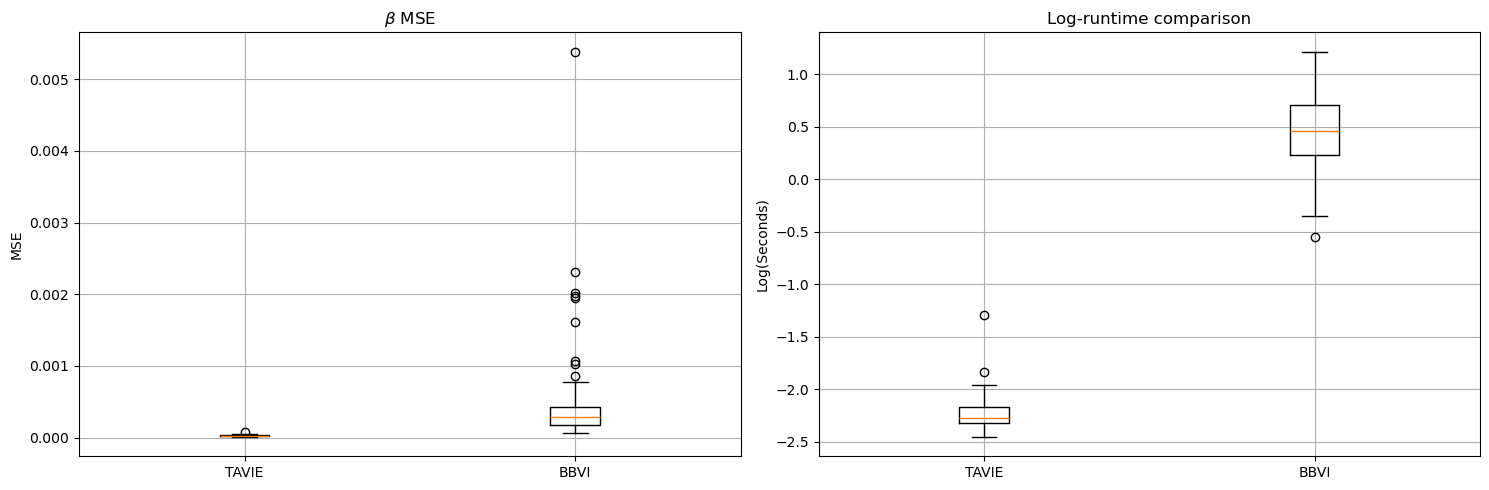

In [7]:
# Plotting results for TAVIE and BBVI
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Beta MSE comparison
axes[0].boxplot([mse_beta_TAVIE, mse_beta_BBVI], tick_labels=['TAVIE', 'BBVI'])
axes[0].set_title(r'$\beta$ MSE')
axes[0].set_ylabel('MSE')
axes[0].grid(True)

# Runtime comparison
axes[1].boxplot([np.log(time_TAVIE), np.log(time_BBVI)], 
                tick_labels=['TAVIE', 'BBVI'])
axes[1].set_title('Log-runtime comparison')
axes[1].set_ylabel('Log(Seconds)')
axes[1].grid(True)

plt.tight_layout()
plt.show()